# Capstone Project : Logistic Regression

In this notebook, we build a logistic regression classifier to predict the likelihood of churn given customer demographics, customer account information and customer services.

In [4]:
# Import Packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from pylab import rcParams
import math

from imblearn.pipeline import Pipeline as pl
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, cohen_kappa_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from yellowbrick.classifier import DiscriminationThreshold

import warnings
warnings.filterwarnings('ignore')

#%%javascript
#IPython.OutputArea.prototype._should_scroll = function(lines) {
#    return false;
#}

# global set
pd.set_option('display.max_columns', None)

In [5]:
#Define the plot Function
def result(model, X_train, y_train, X_test, y_test, train_result, clf_name):
    """ This function calculates different metrics to show the model's performance on both training and test data.
    This functoin also shows the confusion matrix, and plots the ROC and PR curves.
    
    Parameters
    ----------
    model (dtype: sklearn.model_selection._search.GridSearchCV) : The classifier model
    train_result (dtype: boolean): If YES, calculate results for train data
    clf_name (dtype: str): Name of the classifier
    """
    if train_result:
        y_pred_train = model.predict(X_train) # class prediction
        y_pred_train_prob = model.predict_proba(X_train) # probability of each class prediction
        print("#####################")
        print("Train data")
        print("#####################")
        print("F1: ", metrics.f1_score(y_train, y_pred_train))
        print("Cohen Kappa: ", metrics.cohen_kappa_score(y_train, y_pred_train))
        print("Brier: ", metrics.brier_score_loss(y_train, y_pred_train))
        print("LogLoss: ", metrics.log_loss(y_train, y_pred_train_prob))
        print(metrics.classification_report(y_train, y_pred_train))
        print(metrics.confusion_matrix(y_train, y_pred_train))
    else:
        pass
    
    y_pred_test = model.predict(X_test)
    y_pred_test_prob = model.predict_proba(X_test)
    print("#####################")
    print("Test data")
    print("#####################")
    print("F1: ", metrics.f1_score(y_test, y_pred_test))
    print("Cohen Kappa: ", metrics.cohen_kappa_score(y_test, y_pred_test))
    print("Brier: ", metrics.brier_score_loss(y_test, y_pred_test))
    print("LogLoss: ", metrics.log_loss(y_test, y_pred_test_prob))
    print(metrics.classification_report(y_test, y_pred_test))
    conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)
    
    # Displaying the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', fontsize=24)

    plt.title('Confusion Matrix for %s' % clf_name, size=20)
    plt.xlabel('Predicted label', size=20)
    plt.ylabel('True label', size=20)
    ax.tick_params('x', labelsize = 20)
    ax.tick_params('y', labelsize = 20)
    plt.tight_layout()
    
    # ROC curve
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='Model Performance (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], 
             [0, 1], 
             '--', 
             color=(0.6, 0.6, 0.6), 
             label='Luck')
    
    plt.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2,
             linestyle=':',
             color='black',
             label='Perfect Performance')
        
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', size=20)
    plt.ylabel('True Positive Rate', size=20)
    plt.title('Receiver Operating Characteristic for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="lower right", fontsize=18)
    
    # PR curve
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    prec, recall, thresholds = precision_recall_curve(y_test, y_pred_test_prob[:, 1])
    #pr_auc = auc(prec, recall)
    plt.plot(recall, prec, lw=1, label='Model Performance (area = %0.2f)' % 
             (metrics.average_precision_score(y_test, y_pred_test_prob[:, 1])))    
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('Recall', size=20)
    plt.ylabel('Precision', size=20)
    plt.title('PR Curve for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="top right", fontsize=18)

# Preprocessing the Data
We have acquired and cleaned the data in this IPython Notebook. All the features were used for this analysis. Let's get the data prepared for modeling.

In [6]:
# global set
pd.set_option('display.max_columns', None)

# Load the data
telco = pd.read_csv("telco_eda.csv") 

# recode the features
# tranform to dummy variable
binvar = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
          'PaperlessBilling', 'Churn']
for col in binvar:
    telco[col] = telco[col].apply(lambda x: 1 if x=='Yes' else 0 )
    
transformed_telco = pd.get_dummies(telco)
transformed_telco.shape

# Train/test split
X = transformed_telco.drop(["Churn"], axis=1).values
y = transformed_telco.Churn.astype(int).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify = y)

# Logistic Regression - Random Under Sampling, Scaling 

In [7]:
%%time

# Steps for pipeline
steps = [("rus", RandomUnderSampler(random_state=30)),
         ("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", LogisticRegression(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(model__C = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
                  model__penalty = ['l1', 'l2'])

# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
LRrusPR = GridSearchCV(pipe, 
                       param_grid = param_grid, 
                       verbose = 3,
                       cv = cv,
                       n_jobs=-1,
                       scoring='average_precision',
                       iid=False)

# Training using CV
LRrusPR.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  73 out of  80 | elapsed:   28.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   28.9s finished


CPU times: user 613 ms, sys: 150 ms, total: 763 ms
Wall time: 30.2 s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=20, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rus',
                                        RandomUnderSampler(random_state=30,
                                                           replacement=False,
                                                           sampling_strategy='auto')),
                                       ('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=...
                                                           multi_class='

In [12]:
LRrusPR.best_params_

{'model__C': 0.1, 'model__penalty': 'l2'}

#####################
Test data
#####################
F1:  0.6064382139148494
Cohen Kappa:  0.41680765642754725
Brier:  0.26936744847192606
LogLoss:  0.5172422143249064
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.78      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.75      1407



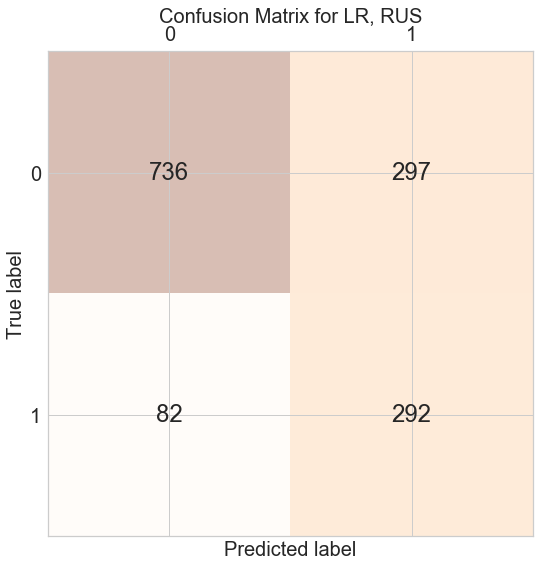

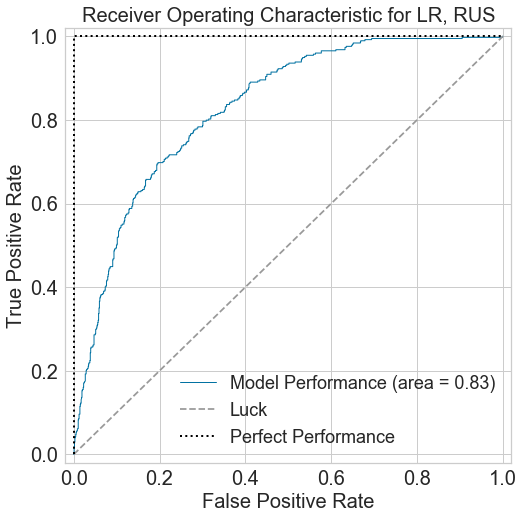

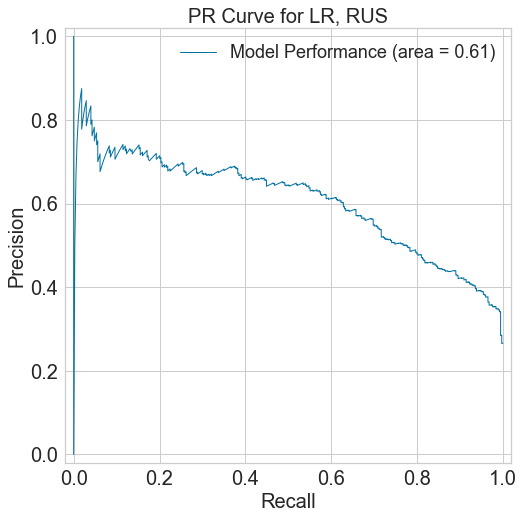

In [13]:
result(LRrusPR, X_train, y_train, X_test, y_test, 
       train_result=False, clf_name="LR, RUS")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  73 out of  80 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  73 out of  80 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.5s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  73 out of  80 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.6s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.0s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.5s finished


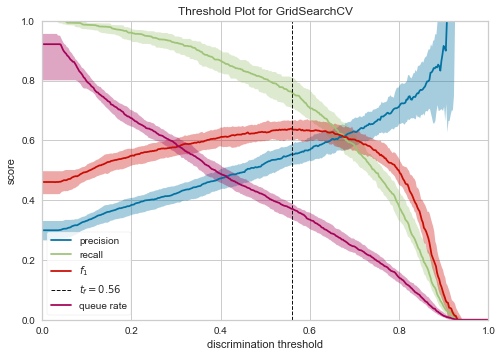

In [32]:
visualizer = DiscriminationThreshold(LRrusPR)
visualizer.fit(X_train,y_train)
visualizer.poof()

# Logistic Regression - Scaling, Using Class Weight

In [9]:
%%time
# Steps for pipeline
steps = [("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", LogisticRegression(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(model__C = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
                  model__penalty = ['l1', 'l2'],
                  model__class_weight = ['balanced']
                  )
# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
LRcw = GridSearchCV(pipe, 
                    param_grid = param_grid, 
                    verbose = 3,
                    cv = cv,
                    n_jobs=-1,
                    scoring='average_precision',
                    iid=False)

# Training using CV
LRcw.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.9s finished


CPU times: user 510 ms, sys: 46.3 ms, total: 556 ms
Wall time: 3.05 s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=20, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                   

In [10]:
LRcw.best_params_

{'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}

#####################
Test data
#####################
F1:  0.610134436401241
Cohen Kappa:  0.4215527723403908
Brier:  0.26794598436389483
LogLoss:  0.5124516544152263
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.75      1407



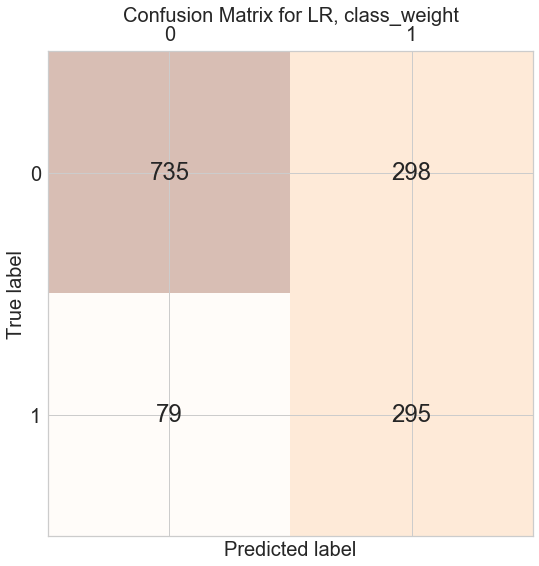

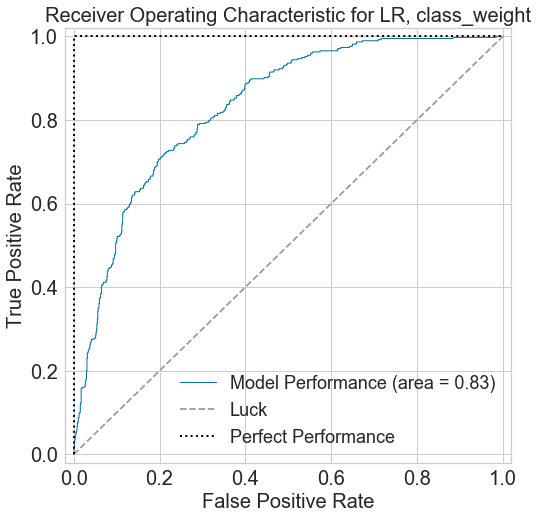

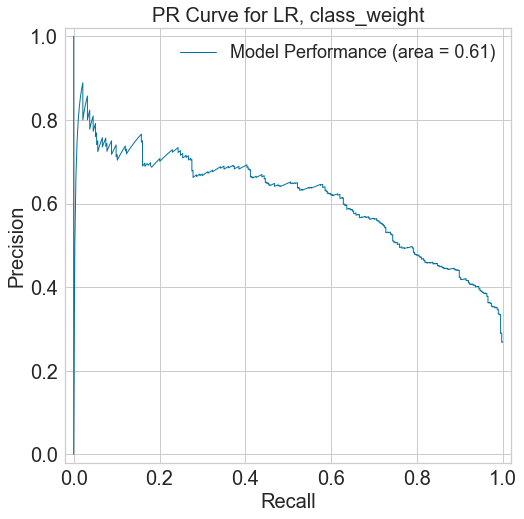

In [14]:
result(LRcw, X_train, y_train, X_test, y_test, 
       train_result=False, clf_name="LR, class_weight")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  73 out of  80 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished


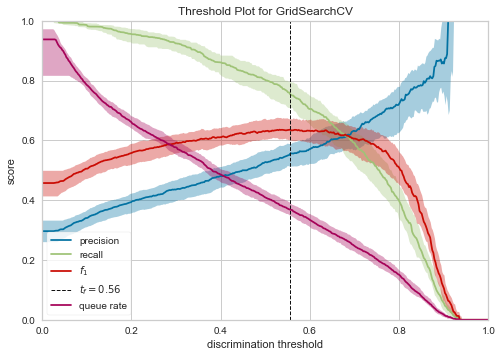

In [20]:
visualizer = DiscriminationThreshold(LRcw)
visualizer.fit(X_train,y_train)
visualizer.poof()

# Logistic Regression - Over Sampling, Scaling 

In [27]:
%%time
# Steps for pipeline
steps = [("smote", SMOTE(random_state=30)),
         ("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", LogisticRegression(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(model__C = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
                  model__penalty = ['l1', 'l2'])

# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
LRsmote = GridSearchCV(pipe, 
                       param_grid = param_grid, 
                       verbose = 4,
                       cv = cv,
                       n_jobs=-1,
                       scoring='average_precision',
                       iid=False)

# Training using CV
LRsmote.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s


CPU times: user 562 ms, sys: 47 ms, total: 609 ms
Wall time: 2.23 s


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.0s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=20, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=30,
                                              sampling_strategy='auto')),
                                       ('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=Fal...
                                                           multi_class='auto',
                  

In [24]:
LRsmote.best_params_

{'model__C': 0.001, 'model__penalty': 'l2'}

#####################
Test data
#####################
F1:  0.6020833333333333
Cohen Kappa:  0.4109176757358679
Brier:  0.27149964463397297
LogLoss:  0.5102289857295897
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.49      0.77      0.60       374

    accuracy                           0.73      1407
   macro avg       0.69      0.74      0.70      1407
weighted avg       0.79      0.73      0.74      1407



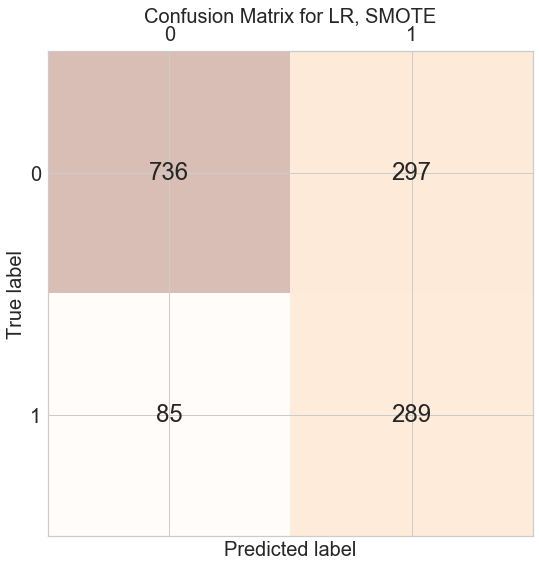

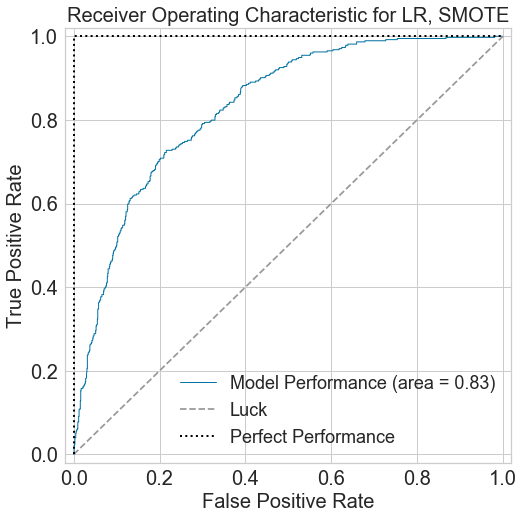

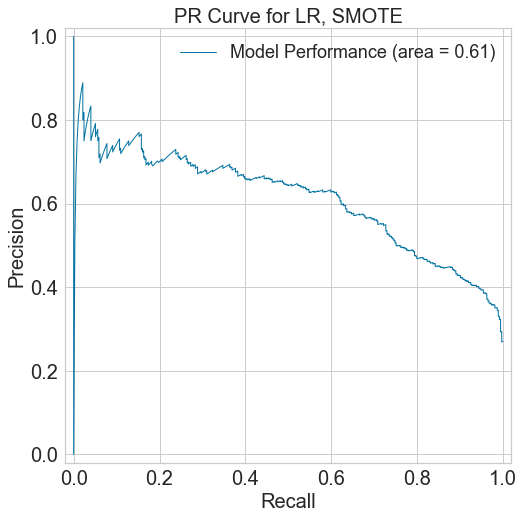

In [28]:
result(LRsmote, X_train, y_train, X_test, y_test, train_result=False, clf_name="LR, SMOTE")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   27.2s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.2s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.2s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.7s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    5.0s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.3s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.2s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.3s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.4s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.4s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.4s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.2s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.0s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.7s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.2s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.0s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.4s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    5.9s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.4s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    7.0s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.7s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    7.5s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.7s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    5.9s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.5s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.4s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.9s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.3s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.1s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.9s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.1s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.4s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    5.7s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.7s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.3s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.3s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.4s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.0s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.9s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.1s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.6s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.4s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.7s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.7s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.0s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.7s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.9s finished


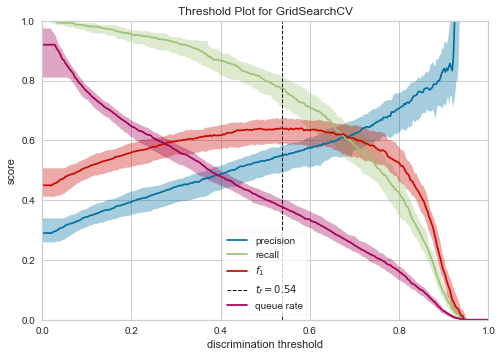

In [36]:
visualizer = DiscriminationThreshold(LRsmote)
visualizer.fit(X_train,y_train)
visualizer.poof()